## Exploring HGMM

Questions:

Across all cells,

- What is the relation between the # of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the FS of chimeras and the # and FS of real molecules (same gene)?
- What is the relation between the # of chimeras and number of real molecules (other genes)?

In a given cell,

- What is the relation between the total # of real molecules and expression of inidividual genes (notion of droplet efficiency)?
- What is the relation between the # of chimeras (summed over all genes) and the # of real molecules (summed over all genes)?

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *
import tables
import scipy.sparse as sp

from fingerprint import SingleCellFingerprintBase, SingleCellFingerprintDTM

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [ ]:
dataset_name = 'hgmm_1k'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm'
mol_info_h5_path = '/home/jupyter/data/10x/hgmm_1k_molecule_info.h5'

In [113]:
dataset_name = 'hgmm_1k'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_v2_only_expressing_sc_fingerprint.pkl'
mol_info_h5_path = '/home/jupyter/data/10x/hgmm_1k_molecule_info.h5'

In [47]:
dataset_name = 'hgmm_1k_merged'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_merged_sc_fingerprint.pkl'
mol_info_h5_path = '/home/jupyter/data/10x/hgmm_1k_merged_molecule_info.h5'

In [71]:
dataset_name = 'hgmm_1k_merged'
sc_fingerprint_path = '/home/jupyter/data/10x/hgmm_1k_ncm_merged_sc_fingerprint.pkl'
mol_info_h5_path = '/home/jupyter/data/10x/hgmm_1k_ncm_merged_molecule_info.h5'

In [113]:
dataset_name = 'cho_hca_1'
sc_fingerprint_path = '/home/jupyter/data/10x/CHO_HCA_1_sc_fingerprint.pkl'
mol_info_h5_path = '/home/jupyter/data/10x/CHO_HCA_1_molecule_info.h5'

In [114]:
# load fingerprint and instantiate the data-store
sc_fingerprint_base = SingleCellFingerprintBase.load(sc_fingerprint_path)
sc_fingerprint_base = sc_fingerprint_base.filter_genes(
    max_good_turing=1.,
    min_total_gene_expression=1.).sort_genes_by_expression()
sc_fingerprint_dtm = SingleCellFingerprintDTM(sc_fingerprint_base)

Calculating and caching "SingleCellFingerprintBase.good_turing_estimator_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Number of genes failed the maximum Good-Turing criterion: 0
Number of genes failed the minimum expression criterion: 0
Number of genes failed both criteria: 0
Number of retained genes: 38696
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.total_molecules_per_gene_g"...
Calculating and caching "SingleCellFingerprintBase.sparse_count_matrix_csr"...


In [73]:
mol_h5_tab = tables.open_file(mol_info_h5_path) 

# for CR v2
gene_names_array = mol_h5_tab.root.gene_names.read()
gene_ids_array = mol_h5_tab.root.gene_ids.read()

# # for CR v3
# gene_names_array = mol_h5_tab.root.features.name.read()
# gene_ids_array = mol_h5_tab.root.features.id.read()

In [74]:
human_prefix = 'hg19'
mouse_prefix = 'mm10'
human_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if gene_ids_array[gene_idx].decode('ascii').find(human_prefix) != -1]
mouse_gene_indices = [i_gene
                      for i_gene, gene_idx in enumerate(sc_fingerprint_base.gene_idx_list)
                      if gene_ids_array[gene_idx].decode('ascii').find(mouse_prefix) != -1]

In [75]:
joint_count_matrix_csc = sp.csc_matrix(sc_fingerprint_base.sparse_count_matrix_csr)
human_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, human_gene_indices])
mouse_count_matrix_csr = sp.csr_matrix(joint_count_matrix_csc[:, mouse_gene_indices])

In [76]:
human_total_expr = np.asarray(np.sum(human_count_matrix_csr, -1)).flatten()
mouse_total_expr = np.asarray(np.sum(mouse_count_matrix_csr, -1)).flatten()

In [77]:
human_cell_indices = np.where((human_total_expr > 1e3) & (mouse_total_expr < 2e3))[0]
mouse_cell_indices = np.where((mouse_total_expr > 1e3) & (human_total_expr < 2e3))[0]

Text(0.5, 0, 'Human UMI count')

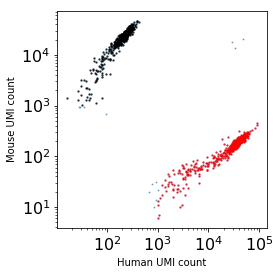

In [78]:
plt.scatter(human_total_expr, mouse_total_expr, s=1, alpha=0.5)
plt.scatter(human_total_expr[human_cell_indices], mouse_total_expr[human_cell_indices], color='red', s=2, alpha=0.5)
plt.scatter(human_total_expr[mouse_cell_indices], mouse_total_expr[mouse_cell_indices], color='black', s=2, alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')
plt.ylabel('Mouse UMI count')
plt.xlabel('Human UMI count')

In [79]:
def get_cell_summed_fsd(gene_index, cell_indices):
    return np.sum(
        sc_fingerprint_dtm.get_single_gene_dense_fingerprint_array(gene_index)[cell_indices, :], 0)

## Fitting real and chimeric FSD

In [80]:
import torch
from pyro_extras import NegativeBinomial
from torch.distributions import Multinomial

dtype = torch.float
device = torch.device("cpu")

def get_nb_fit_loss(empirical_histgram, log_mu, log_phi, device, dtype):
    # histogram loss
    max_family_size = empirical_histgram.shape[0]
    total_count = empirical_histgram.sum().item()
    family_size_vector_obs = torch.arange(1, max_family_size + 1, device=device, dtype=dtype)

    # calculate NB log prob
    mu = log_mu.exp()
    phi = log_phi.exp()
    alpha = phi.reciprocal()
    nb_log_prob = ((family_size_vector_obs + alpha).lgamma() - (family_size_vector_obs + 1).lgamma() - alpha.lgamma()
            + alpha * (alpha.log() - (alpha + mu).log())
            + family_size_vector_obs * (mu.log() - (alpha + mu).log()))
    
    # calculate multonimial log prob
    nb_log_prob = nb_log_prob - torch.logsumexp(nb_log_prob, 0)
    return -(empirical_histgram * nb_log_prob).sum()


def fit_nb(empirical_histgram,
           max_iters = 10_000,
           abs_tol = 1e-4,
           lr = 1e-1,
           fixed_log_phi = None,
           fixed_log_mu = None,
           device=torch.device('cpu'),
           dtype=torch.float):
    # send data to device
    empirical_histgram = torch.tensor(empirical_histgram.astype(np.float), device=device, dtype=dtype)
    
    init_mu = 0.5
    init_phi = 0.2
    
    params = []

    if fixed_log_mu is not None:
        log_mu = torch.tensor(fixed_log_mu, device=device, dtype=dtype)
    else:
        init_log_mu = np.log(0.5)
        log_mu = torch.nn.Parameter(torch.tensor(init_log_mu, device=device, dtype=dtype))
        params.append(log_mu)

    if fixed_log_phi is not None:
        log_phi = torch.tensor(fixed_log_phi, device=device, dtype=dtype)
    else:
        init_log_phi = np.log(0.2)
        log_phi = torch.nn.Parameter(torch.tensor(init_log_phi, device=device, dtype=dtype))
        params.append(log_phi)
        
    # optimizer
    opt = torch.optim.LBFGS(params, lr=lr)
    
    def closure():
        opt.zero_grad()
        loss = get_nb_fit_loss(empirical_histgram, log_mu, log_phi, device, dtype)
        loss.backward()
        return loss

    prev_params = None
    converged = False
    for i_iter in range(max_iters):
        
        # step
        opt.step(closure)

        new_params = [log_mu.item(), log_phi.item()]
        if prev_params is not None:
            mu_abs_res = np.abs(new_params[0] - prev_params[0])
            phi_abs_res = np.abs(new_params[1] - prev_params[1])
            if max(mu_abs_res, phi_abs_res) < abs_tol:
                converged = True
                break
        prev_params = new_params
        
    if converged:
        return {
            'log_mu': log_mu.item(),
            'log_phi': log_phi.item()}
    else:
        print(new_params)
        raise RuntimeError('NB fit did not converge -- increase `max_iters` or decrease `rel_tol`')

In [115]:
i_gene = 8
human_fsd = get_cell_summed_fsd(i_gene, human_cell_indices)
mouse_fsd = get_cell_summed_fsd(i_gene, mouse_cell_indices)

Calculating and caching "SingleCellFingerprintDTM.collapsed_csr_fingerprint_matrix_cython"...


IndexError: index 1064 is out of bounds for axis 0 with size 1064

In [106]:
if i_gene in mouse_gene_indices:
    mouse_fit = fit_nb(mouse_fsd)
    human_fit = fit_nb(human_fsd)
    print(mouse_fit['log_mu'] - human_fit['log_mu'])
else:
    human_fit = fit_nb(human_fsd)
    mouse_fit = fit_nb(mouse_fsd)
    print(human_fit['log_mu'] - mouse_fit['log_mu'])

0.0749441385269165


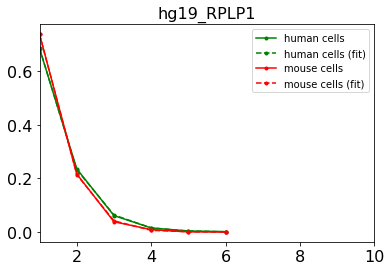

In [107]:
max_family_size = len(human_fsd)

human_fit_dist = NegativeBinomial(mu=np.exp(human_fit['log_mu']), phi=np.exp(human_fit['log_phi']))
human_fit_logits = human_fit_dist.log_prob(torch.arange(1, max_family_size + 1, dtype=torch.float))
human_fit_probs = (human_fit_logits - torch.logsumexp(human_fit_logits, 0)).exp()
human_fit_fsd = np.sum(human_fsd) * human_fit_probs

mouse_fit_dist = NegativeBinomial(mu=np.exp(mouse_fit['log_mu']), phi=np.exp(mouse_fit['log_phi']))
mouse_fit_logits = mouse_fit_dist.log_prob(torch.arange(1, max_family_size + 1, dtype=torch.float))
mouse_fit_probs = (mouse_fit_logits - torch.logsumexp(mouse_fit_logits, 0)).exp()
mouse_fit_fsd = np.sum(mouse_fsd) * mouse_fit_probs


ax = plt.gca()
ax.set_title(gene_names_array[sc_fingerprint_base.gene_idx_list[i_gene]].decode('ascii'), fontsize=16)

ax.plot(np.arange(1, len(human_fsd) + 1), human_fsd / np.sum(human_fsd), label='human cells', color='green', marker='.')
ax.plot(np.arange(1, len(human_fsd) + 1), human_fit_fsd.numpy() / np.sum(human_fit_fsd.numpy()), '--', label='human cells (fit)', color='green', marker='.')

ax.plot(np.arange(1, len(mouse_fsd) + 1), mouse_fsd / np.sum(mouse_fsd), label='mouse cells', color='red', marker='.')
ax.plot(np.arange(1, len(mouse_fsd) + 1), mouse_fit_fsd.numpy() / np.sum(mouse_fit_fsd.numpy()), '--', label='mouse cells (fit)', color='red', marker='.')

ax.set_xlim((1, 10))

# ax.set_yscale('log')
ax.legend()

## Number of chimeras vs number of reals

In [108]:
human_count_matrix = sc_fingerprint_base.sparse_count_matrix_csr[human_cell_indices, :]
mouse_count_matrix = sc_fingerprint_base.sparse_count_matrix_csr[mouse_cell_indices, :]

chimeras_in_human_per_mouse_gene = np.asarray(np.sum(human_count_matrix[:, mouse_gene_indices], 0)).flatten()
chimeras_in_mouse_per_human_gene = np.asarray(np.sum(mouse_count_matrix[:, human_gene_indices], 0)).flatten()

reals_in_mouse_per_mouse_gene = np.asarray(np.sum(mouse_count_matrix[:, mouse_gene_indices], 0)).flatten()
reals_in_human_per_human_gene = np.asarray(np.sum(human_count_matrix[:, human_gene_indices], 0)).flatten()

Text(0, 0.5, 'Total chimeric hg19 in mm10')

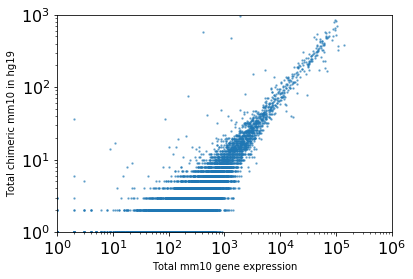

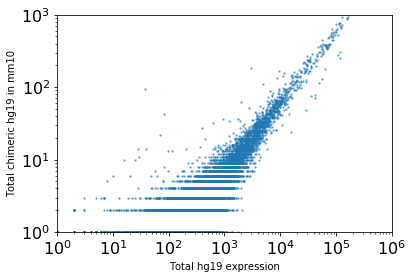

In [109]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(reals_in_mouse_per_mouse_gene, chimeras_in_human_per_mouse_gene, s=2, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1, 1e6))
ax.set_ylim((1, 1e3))
ax.set_xlabel('Total mm10 gene expression')
ax.set_ylabel('Total chimeric mm10 in hg19')


fig = plt.figure()
ax = plt.gca()
ax.scatter(reals_in_human_per_human_gene, chimeras_in_mouse_per_human_gene, s=2, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((1, 1e6))
ax.set_ylim((1, 1e3))
ax.set_xlabel('Total hg19 expression')
ax.set_ylabel('Total chimeric hg19 in mm10')

## Number of chimeras vs family size of reals

In [110]:
mouse_gene_mean_fs = np.zeros((len(mouse_gene_indices),))
family_size_vector_obs = np.arange(1, sc_fingerprint_base.max_family_size + 1)
for i_gene_mouse, i_gene in enumerate(mouse_gene_indices):
    empirical_fsd = get_cell_summed_fsd(i_gene, mouse_cell_indices).astype(np.float)
    empirical_fsd_normed = empirical_fsd / (1e-12 + np.sum(empirical_fsd))
    mouse_gene_mean_fs[i_gene_mouse] = np.dot(empirical_fsd_normed, family_size_vector_obs)

In [111]:
# filters
mask = (reals_in_mouse_per_mouse_gene > 500) & (chimeras_in_human_per_mouse_gene < 0.1 * reals_in_mouse_per_mouse_gene)
normed_chimera_rate_masked = chimeras_in_human_per_mouse_gene.astype(np.float)[mask] / (
    reals_in_mouse_per_mouse_gene.astype(np.float)[mask])
mouse_gene_mean_fs_masked = mouse_gene_mean_fs[mask]

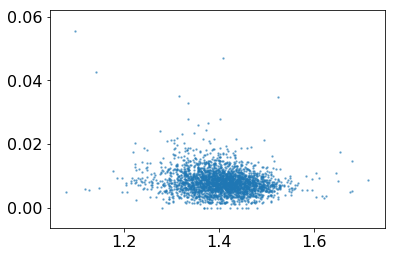

In [112]:
plt.scatter(mouse_gene_mean_fs_masked, normed_chimera_rate_masked, s=2, alpha=0.5)
# plt.ylim((0, 0.05))
# plt.xlim((1, 2))

## Number of chimeras of species A vs total of species B reals ("cell size")

In [136]:
chimeras_in_human_per_per_cell = np.sum(np.asarray(human_count_matrix[:, mouse_gene_indices].todense()), -1)
reals_in_human_per_cell = np.sum(np.asarray(human_count_matrix[:, human_gene_indices].todense()), -1)

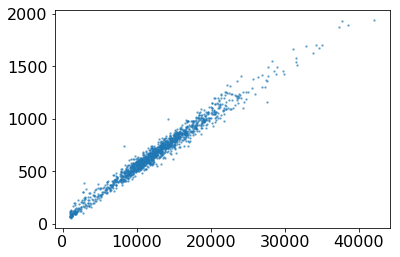

In [137]:
plt.scatter(reals_in_human_per_cell, chimeras_in_human_per_per_cell, s=2, alpha=0.5)

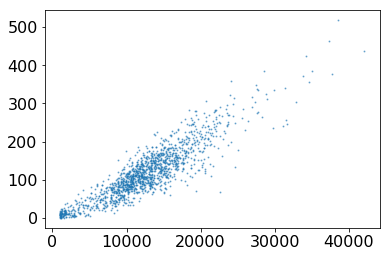

In [138]:
plt.scatter(reals_in_human_per_cell,
            np.asarray(human_count_matrix[:, human_gene_indices[7]].todense()).flatten(),
            s=1, alpha=0.5)

## Estimates

In [139]:
chimera_to_real_ratio_list = []
fsd_mu_real = []
fsd_mu_chimera = []

for i_gene_human in range(2000):
    i_gene = human_gene_indices[i_gene_human]

    human_fsd = get_cell_summed_fsd(i_gene, human_cell_indices)
    mouse_fsd = get_cell_summed_fsd(i_gene, mouse_cell_indices)

    if i_gene_human % 10 == 0:
        print(i_gene_human)
        
    try:
        mouse_fit = fit_nb(mouse_fsd, fixed_log_phi=0.0)
        human_fit = fit_nb(human_fsd)
    except:
        pass

    p_obs_real = 1 - NegativeBinomial(mu=np.exp(human_fit['log_mu']), phi=np.exp(human_fit['log_phi'])).log_prob(torch.tensor(0.)).exp()
    p_obs_chimera = 1 - NegativeBinomial(mu=np.exp(mouse_fit['log_mu']), phi=np.exp(mouse_fit['log_phi'])).log_prob(torch.tensor(0.)).exp()
    
    obs_chimera_per_cell = np.mean(np.asarray(sc_fingerprint_base.sparse_count_matrix_csr[mouse_cell_indices, i_gene].todense()))
    total_chimera_per_cell = (obs_chimera_per_cell / p_obs_chimera).item()

    obs_real_per_cell = np.mean(np.asarray(sc_fingerprint_base.sparse_count_matrix_csr[human_cell_indices, i_gene].todense()))
    total_real_per_cell = (obs_real_per_cell / p_obs_real).item()
    
    chimera_to_real_ratio = total_chimera_per_cell / total_real_per_cell
    chimera_to_real_ratio_list.append(chimera_to_real_ratio)
    fsd_mu_real.append(np.exp(human_fit['log_mu']))
    fsd_mu_chimera.append(np.exp(mouse_fit['log_mu']))

0
10
20
30
40
50
60


KeyboardInterrupt: 

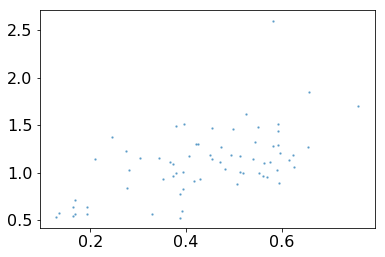

In [140]:
plt.scatter(fsd_mu_real, chimera_to_real_ratio_list, s=2, alpha=0.5)
# plt.ylim((0, 0.05))

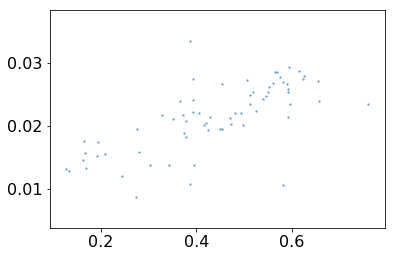

In [141]:
plt.scatter(fsd_mu_real, fsd_mu_chimera, s=2, alpha=0.5)

## Takeaway

1. chimera counts scale with real counts (for every gene)
2. both real and chimeric counts scale linearly with the total number of UMI per cell ("droplet efficiency")
3. the absolute chimera rate is ~ 0.02-0.10 and does not seem to depend on the FSD of real molecules
4. mean fs for chimeric molcules (assuming a geometric distribution, which seems to be OK) does not seems to depend onf the FSD of real molecules